In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results"
ref_bim = "/cluster/projects/p33/users/elizabept/multimodal/discovery/genos/results/UKB34886_T1_QCed_230222.bim"

In [3]:
bim = pd.read_csv(ref_bim, sep='\t', header=None, names=["SNP","A1"], usecols=[1,4])
print(bim.shape)
bim.head()

(9061586, 2)


,SNP,A1
0,rs533090414,C
1,rs28619159,C
2,rs539032812,C
3,rs12238997,G
4,rs200531508,A


In [26]:
def save_zmat(gwas_des, zmat_prefix, bim):
    zmat_dat_fname = f"{zmat_prefix}.dat" # z-scores in binary format
    zmat_col_fname = f"{zmat_prefix}.cols" # variants
    zmat_row_fname = f"{zmat_prefix}.rows" # phenotypes
    
    # save column and row ids
    pd.Series([de.name for de in gwas_des]).to_csv(zmat_row_fname, header=None, index=False)
    bim.SNP.to_csv(zmat_col_fname, header=None, index=False)
    
    # save binary data
    zmat_shape = (len(gwas_des), bim.shape[0])
    zmat = np.memmap(zmat_dat_fname, dtype='float32', mode='w+', offset=0, shape=zmat_shape, order='C')
    for i,de in enumerate(gwas_des):
        print(i, end=' ')
        df = pd.read_table(de.path, sep='\t', usecols=["ID","A1","T_STAT"])
        assert (df.ID == bim.SNP).all()
        i_swap_sign = df.A1!=bim.A1
        df.loc[i_swap_sign,"T_STAT"] *= -1
        zmat[i] = df.T_STAT.values
        zmat.flush()
        
def get_gwas_des(dir2use, h2_summary_df=None, h2_z_threshold=1.96, contains_str=None):
    if not h2_summary_df is None:
        pheno2use = h2_summary_df.loc[h2_summary_df.h2_z>h2_z_threshold, "pheno"]
    print(f"{len(pheno2use)} phenotypes with h2_z > {h2_z_threshold}")
    pheno2use.sort_values(axis=0, inplace=True)
    pheno2use = list(pheno2use)
    gwas_des = [de for de in os.scandir(dir2use)
                if de.name.endswith(".linear")
                    and (contains_str is None or contains_str in de.name)
                    and de.name.split('.')[1] in pheno2use]
    gwas_des.sort(key=lambda de: de.name)
    print(f"{len(gwas_des)} GWAS files in {dir2use}")
    return gwas_des

def get_gwas_des_from_pheno_list(in_dir, pheno_list):
    gwas_des = [None]*len(pheno_list)
    for de in os.scandir(in_dir):
        gwas_pheno = de.name.split('.')[1]
        if gwas_pheno in pheno_list:
            ind = pheno_list.index(de.name.split('.')[1])
            gwas_des[ind] = de
    assert all(gwas_des)
    return gwas_des

In [5]:
h2_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2"
summary_df = pd.read_table(f"{h2_dir}/summary_schaefer.txt")
print(summary_df.shape)
summary_df.head()

(3555, 10)


,pheno,h2,h2_se,Labmda_GC,Mean_Chi2,Intercept,Intercept_se,Ratio,Ratio_se,h2_z
0,3rd_Ventricle,0.2826,0.0245,1.1523,1.2123,1.0223,0.0069,0.1052,0.0323,11.53470
1,4th_Ventricle,0.3143,0.0258,1.1747,1.2431,1.0274,0.0089,0.1127,0.0365,12.18220
2,5th_Ventricle,0.0653,0.0139,1.0557,1.0479,1.0043,0.0060,0.09,0.1257,4.69784
3,Brain_Stem,0.3080,0.0236,1.1683,1.2239,1.0153,0.0072,0.0685,0.0323,13.05080
4,CC_Anterior,0.3140,0.0252,1.1747,1.2319,1.0219,0.0082,0.0946,0.0354,12.46030


In [7]:
# Save orig z scores
# Phenotypes in rows, variants in columns.
# Sort phenotypes in lexicographical order, the order of variants is as in reference bim file.
orig_dir = os.path.join(gwas_dir, "orig")
zmat_prefix = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_h2z196_elbow_orig_040522"
gwas_des = get_gwas_des(orig_dir, summary_df, h2_z_threshold=1.96, contains_str=None)
gwas_des_elbow = []
gwas_des = [de for de in gwas_des if not (("node" in de.name) or ("edge" in de.name))] # drop old functional
for de in gwas_des:
    p = de.name.split(".")[1]
    if ( not (p.startswith("N0_") or p.startswith("ND_") or p.startswith("NF_"))
                  or ( p.startswith("N0_") and int(p.split("PCs")[-1])<66 )
                  or ( p.startswith("ND_") and int(p.split("PCs")[-1])<125 )
                  or ( p.startswith("NF_") and int(p.split("PCs")[-1])<88 ) ):
        gwas_des_elbow.append(de)

print(len(gwas_des_elbow))

save_zmat(gwas_des_elbow, zmat_prefix, bim) 

2279 phenotypes with h2_z > 1.96
2279 GWAS files in /cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/orig
583
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 

In [48]:
# Save perm z scores
perm_dir = os.path.join(gwas_dir, "perm")
zmat_prefix = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_perm_h2z196"
gwas_des = get_gwas_des(perm_dir, summary_df, h2_z_threshold=1.96, contains_str="perm.")
save_zmat(gwas_des, zmat_prefix, bim)

402 GWAS files in /cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/perm
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 25

In [40]:
def extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out):
    zmat_dat_in_fname = f"{zmat_prefix_in}.dat" # z-scores in binary format
    zmat_col_in_fname = f"{zmat_prefix_in}.cols" # variants
    zmat_row_in_fname = f"{zmat_prefix_in}.rows" # phenotypes
    
    pheno = pd.read_csv(zmat_row_in_fname, header=None, names=["PHENO"]).squeeze("columns")
    pheno_ind_2take = [i for i,p in enumerate(pheno) if p in pheno_list]
    print(f"{len(pheno_ind_2take)} out of {len(pheno_list)} phenotypes found")
    
    zmat_dat_out_fname = f"{zmat_prefix_out}.dat" # z-scores in binary format
    zmat_col_out_fname = f"{zmat_prefix_out}.cols" # variants
    zmat_row_out_fname = f"{zmat_prefix_out}.rows" # phenotypes

    pd.Series(pheno_list).to_csv(zmat_row_out_fname, header=None, index=False)
    snp = pd.read_csv(zmat_col_in_fname, header=None)
    snp.to_csv(zmat_col_out_fname, header=None, index=False)

    zmat_in_shape = (pheno.shape[0], snp.shape[0])
    zmat_in = np.memmap(zmat_dat_in_fname, dtype='float32', mode='r+', offset=0, shape=zmat_in_shape, order='C')

    zmat_out_shape = (len(pheno_list), snp.shape[0])
    zmat_out = np.memmap(zmat_dat_out_fname, dtype='float32', mode='w+', offset=0, shape=zmat_out_shape, order='C')
    zmat_out[:] = zmat_in[pheno_ind_2take]
    zmat_out.flush()


In [20]:
# extract modality-specific z-scores

zmat_prefix_in = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_h2z196_elbow_perm_040522"
pheno_names2extract = [f"conn{i}" for i in range(1,137)] + "VisPeri VisCent TempPar SomMotB SomMotA SalVentAttnB SalVentAttnA LimbicB LimbicA DorsAttnB DorsAttnA DefaultC DefaultB DefaultA ContC ContB ContA".split()
pheno_files = pd.read_csv(f"{zmat_prefix_in}.rows", header=None).squeeze()
pheno_files2extract = [p for p in pheno_files if p.split('.')[1] in pheno_names2extract]
zmat_prefix_out = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_func_h2z196_elbow_perm_040522"
print(len(pheno_files2extract))
extract_zmat_pheno(zmat_prefix_in, pheno_files2extract, zmat_prefix_out)

139
139 out of 139 phenotypes found


In [33]:
zmat_prefix_in = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_perm"
gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/perm"
pheno_list = [de.name for de in os.scandir(gwas_dir) if ("edge" in de.name or "node" in de.name)]
zmat_prefix_out = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_rsfmri_perm"
print(len(pheno_list))
extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)

231
231 out of 231 phenotypes found


In [37]:
zmat_prefix_in = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_orig"
gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/orig"
pheno_list = [de.name for de in os.scandir(gwas_dir) if not ("edge" in de.name or "node" in de.name)]
zmat_prefix_out = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_T1_orig"
print(len(pheno_list))
extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)

171
171 out of 171 phenotypes found


In [40]:
zmat_prefix_in = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_perm"
gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/perm"
pheno_list = [de.name for de in os.scandir(gwas_dir) if (not ("edge" in de.name or "node" in de.name)) and (de.name.endswith("linear"))]
zmat_prefix_out = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_T1_perm"
print(len(pheno_list))
extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)

171
171 out of 171 phenotypes found


In [16]:
# heritable pheno
insig_pheno_fname = "/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2/insig_pheno.txt"
print(insig_pheno_fname)
insig_pheno = set(pd.read_csv(insig_pheno_fname, header=None, names=["PHENO"]).squeeze("columns"))
print(f"{len(insig_pheno)} insignificant phenotypes")
for orig_perm in ["orig", "perm"]:
    gwas_dir = f"/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/{orig_perm}"
    pheno_list = [de.name for de in os.scandir(gwas_dir) if (de.name.endswith('.linear')) and (not de.name.split('.')[1] in insig_pheno)]
    print(f"{len(pheno_list)} significant phenotypes in {orig_perm}")
    zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_{orig_perm}"
    zmat_prefix_out = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_h205_{orig_perm}"
    extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)


/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2/insig_pheno.txt
76 insignificant phenotypes
326 significant phenotypes in orig
326 out of 326 phenotypes found
326 significant phenotypes in perm
326 out of 326 phenotypes found


In [68]:
# heritable diffusion pheno
h2_z_threshold = 1.96
h2_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2"
summary_df = pd.read_table(f"{h2_dir}/summary.txt")
sig_pheno =  [p for p in list(summary_df.loc[summary_df.h2_z>h2_z_threshold, "pheno"]) if p[:3] in ("N0_","ND_","NF_")]
print(f"{len(sig_pheno)} significant phenotypes")
if True:
    for orig_perm in ["orig", "perm"]:
        gwas_dir = f"/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/{orig_perm}"
        pheno_list = [de.name for de in os.scandir(gwas_dir) if (de.name.endswith('.linear')) and (de.name.split('.')[1] in sig_pheno) and (de.name.split('.')[0].split("_")[-1] in ("orig","perm"))]
        print(f"{len(pheno_list)} significant phenotypes in {orig_perm}")
        zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_{orig_perm}_h2z196"
        zmat_prefix_out = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_diffusion_h2z196_{orig_perm}"
        extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)


1814 significant phenotypes
1814 significant phenotypes in orig
1814 out of 1814 phenotypes found
1814 significant phenotypes in perm
1814 out of 1814 phenotypes found


In [5]:
# heritable functional pheno
insig_pheno_fname = "/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2/insig_pheno.txt"
print(insig_pheno_fname)
insig_pheno = set(pd.read_csv(insig_pheno_fname, header=None, names=["PHENO"]).squeeze("columns"))
print(f"{len(insig_pheno)} insignificant phenotypes")
for orig_perm in ["orig", "perm"]:
    gwas_dir = f"/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/{orig_perm}"
    pheno_list = [de.name for de in os.scandir(gwas_dir) if (de.name.endswith('.linear')) and (not de.name.split('.')[1] in insig_pheno) and ("edge" in de.name or "node" in de.name)]
    print(f"{len(pheno_list)} significant phenotypes in {orig_perm}")
    zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_{orig_perm}"
    zmat_prefix_out = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_rsfmri_h205_{orig_perm}"
    extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)


/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2/insig_pheno.txt
76 insignificant phenotypes
155 significant phenotypes in orig
155 out of 155 phenotypes found
155 significant phenotypes in perm
155 out of 155 phenotypes found


In [98]:
# pheno h2_z > 1.96 + elbow for diffusion N0=65, ND=124, NF=87
h2_z_threshold = 1.96
h2_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2"
summary_df = pd.read_table(f"{h2_dir}/summary.txt")
pheno2take =  [p for p in list(summary_df.loc[summary_df.h2_z>h2_z_threshold, "pheno"])
               if ( p.startswith("N0_") and int(p.split("PCs")[-1])<66 )
                  or ( p.startswith("ND_") and int(p.split("PCs")[-1])<125 )
                  or ( p.startswith("NF_") and int(p.split("PCs")[-1])<88 ) ]

print(f"{len(pheno2take)} significant phenotypes")
if True:
    for orig_perm in ["orig", "perm"]:
        gwas_dir = f"/cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/{orig_perm}"
        pheno_list = [de.name for de in os.scandir(gwas_dir) if (de.name.endswith('.linear')) and (de.name.split('.')[1] in pheno2take) and (de.name.split('.')[0].split("_")[-1] in ("orig","perm"))]
        print(f"{len(pheno_list)} significant phenotypes in {orig_perm}")
        zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_h2z196_elbow_{orig_perm}"
        zmat_prefix_out = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_diffusion_h2z196_elbow_{orig_perm}"
        extract_zmat_pheno(zmat_prefix_in, pheno_list, zmat_prefix_out)

273 significant phenotypes
273 significant phenotypes in orig
273 out of 273 phenotypes found
273 significant phenotypes in perm
273 out of 273 phenotypes found


In [97]:
171+155+124+87+65-3, 171+155, 124+87+65-3

(599, 326, 273)

In [27]:
# h2 plot
h2_dir = "/cluster/projects/p33/users/elizabept/multimodal/discovery/ldsc/results/h2"
summary_df = pd.read_table(f"{h2_dir}/summary.txt")
summary_df.head()

,pheno,h2,h2_se,Labmda_GC,Mean_Chi2,Intercept,Intercept_se,Ratio,Ratio_se,h2_z
0,3rd_Ventricle,0.2826,0.0245,1.1523,1.2123,1.0223,0.0069,0.1052,0.0323,11.53470
1,4th_Ventricle,0.3143,0.0258,1.1747,1.2431,1.0274,0.0089,0.1127,0.0365,12.18220
2,5th_Ventricle,0.0653,0.0139,1.0557,1.0479,1.0043,0.0060,0.09,0.1257,4.69784
3,Brain_Stem,0.3080,0.0236,1.1683,1.2239,1.0153,0.0072,0.0685,0.0323,13.05080
4,CC_Anterior,0.3140,0.0252,1.1747,1.2319,1.0219,0.0082,0.0946,0.0354,12.46030


['N0_PCs1', 'N0_PCs2', 'N0_PCs3', 'N0_PCs4', 'N0_PCs5']


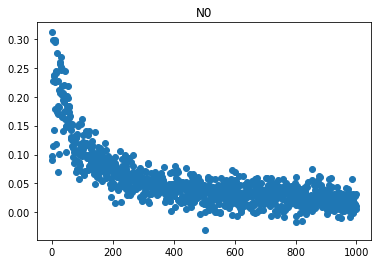

In [17]:
# N0
N0_dict = {p:h2 for p,h2 in zip(summary_df.pheno,summary_df.h2) if p.startswith("N0")}
N0_h2_array = [h2 for p,h2 in sorted(N0_dict.items(), key=lambda ph: int(ph[0][6:]))]
N0_p_array = [p for p,h2 in sorted(N0_dict.items(), key=lambda ph: int(ph[0][6:]))]
print(N0_p_array[:5])
_=plt.scatter(range(len(N0_h2_array)), N0_h2_array)
_=plt.title("N0")

['ND_PCs1', 'ND_PCs2', 'ND_PCs3', 'ND_PCs4', 'ND_PCs5']


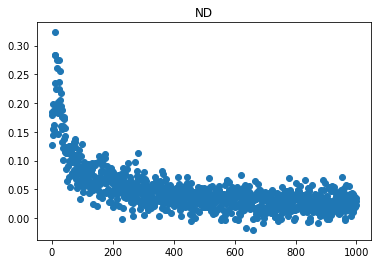

In [18]:
# ND
ND_dict = {p:h2 for p,h2 in zip(summary_df.pheno,summary_df.h2) if p.startswith("ND")}
ND_h2_array = [h2 for p,h2 in sorted(ND_dict.items(), key=lambda ph: int(ph[0][6:]))]
ND_p_array = [p for p,h2 in sorted(ND_dict.items(), key=lambda ph: int(ph[0][6:]))]
print(ND_p_array[:5])
_=plt.scatter(range(len(ND_h2_array)), ND_h2_array)
_=plt.title("ND")

['NF_PCs1', 'NF_PCs2', 'NF_PCs3', 'NF_PCs4', 'NF_PCs5']


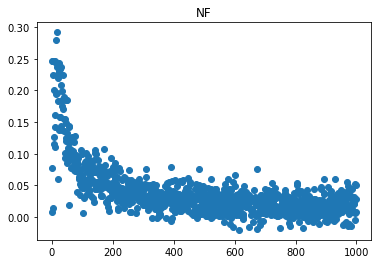

In [19]:
# NF
NF_dict = {p:h2 for p,h2 in zip(summary_df.pheno,summary_df.h2) if p.startswith("NF")}
NF_h2_array = [h2 for p,h2 in sorted(NF_dict.items(), key=lambda ph: int(ph[0][6:]))]
NF_p_array = [p for p,h2 in sorted(NF_dict.items(), key=lambda ph: int(ph[0][6:]))]
print(NF_p_array[:5])
_=plt.scatter(range(len(NF_h2_array)), NF_h2_array)
_=plt.title("NF")

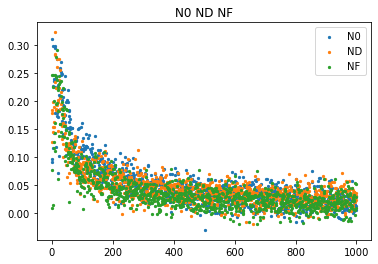

In [23]:
plt.scatter(range(len(N0_h2_array)), N0_h2_array, s=5, label="N0")
plt.scatter(range(len(ND_h2_array)), ND_h2_array, s=5, label="ND")
plt.scatter(range(len(NF_h2_array)), NF_h2_array, s=5, label="NF")
plt.legend()
_=plt.title("N0 ND NF")

In [29]:
summary_df.sort_values(by="h2", ascending=False)

,pheno,h2,h2_se,Labmda_GC,Mean_Chi2,Intercept,Intercept_se,Ratio,Ratio_se,h2_z
8,CC_Posterior,0.3557,0.0252,1.1843,1.2660,1.0234,0.0073,0.088,0.0276,14.11510
221,Left_Caudate,0.3452,0.0259,1.1876,1.2480,1.0189,0.0088,0.0762,0.0357,13.32820
274,lh_pericalcarine_area,0.3360,0.0273,1.1619,1.2492,1.0185,0.0080,0.0744,0.0319,12.30770
1344,ND_PCs13,0.3231,0.0280,1.1555,1.2090,1.0165,0.0079,0.0788,0.0378,11.53930
7,CC_Mid_Posterior,0.3181,0.0197,1.1619,1.2150,0.9995,0.0064,<,NaN,16.14720
...,...,...,...,...,...,...,...,...,...,...
18,edge109,-0.0185,0.0137,0.9957,1.0015,1.0128,0.0059,8.7606,4.0579,-1.35036
2936,NF_PCs673,-0.0196,0.0125,1.0075,1.0057,1.0174,0.0058,3.026,1.0123,-1.56800
2872,NF_PCs615,-0.0203,0.0147,1.0016,0.9969,1.0090,0.0063,NaN,mea,-1.38095
1922,ND_PCs660,-0.0207,0.0139,0.9986,0.9983,1.0105,0.0059,NaN,mea,-1.48921


In [86]:
ii = ~np.array([(p.startswith("edge") or
                 p.startswith("node") or
                 p.startswith("N0") or
                 p.startswith("ND") or
                 p.startswith("NF")) for p in summary_df.pheno.values]) & (summary_df.h2_z>1.96) 
ii.sum()

170

In [9]:
# Save orig z scores
# Phenotypes in rows, variants in columns.
# Sort phenotypes in lexicographical order, the order of variants is as in reference bim file.
orig_dir = os.path.join(gwas_dir, "orig")
zmat_prefix = "/cluster/projects/p33/users/alexeas/elleke/data/zmat_h2z196_elbow_orig_040522"
gwas_des = get_gwas_des(orig_dir, summary_df, h2_z_threshold=1.96, contains_str=None)
gwas_des_elbow = []
#gwas_des = [de for de in gwas_des if not (("node" in de.name) or ("edge" in de.name))] # drop old functional
for de in gwas_des:
    p = de.name.split(".")[1]
    if ( not (p.startswith("N0_") or p.startswith("ND_") or p.startswith("NF_"))
                  or ( p.startswith("N0_") and int(p.split("PCs")[-1])<66 )
                  or ( p.startswith("ND_") and int(p.split("PCs")[-1])<125 )
                  or ( p.startswith("NF_") and int(p.split("PCs")[-1])<88 ) ):
        gwas_des_elbow.append(de)

print(len(gwas_des_elbow))

2279 phenotypes with h2_z > 1.96
2279 GWAS files in /cluster/projects/p33/users/elizabept/multimodal/discovery/plink/results/orig
738


In [34]:
# replication in ABCD European
gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/replication/plink/results/eur"
ref_bim = "/cluster/projects/p33/users/elizabept/multimodal/replication/genos/results/eur/ABCDv3_QCed_hg19_040522.bim"
pheno_file = "/cluster/projects/p33/users/elizabept/multimodal/replication/plink/data/multimodal_phenotypes.txt"
pheno = list(pd.read_csv(pheno_file, header=None).squeeze())
print(f"{len(pheno)} phenotypes")
bim = pd.read_csv(ref_bim, sep='\t', header=None, names=["SNP","A1"], usecols=[1,4])
print(bim.shape)
bim.head()

522 phenotypes
(8175329, 2)


,SNP,A1
0,rs75935175,G
1,rs61769339,A
2,rs61769340,G
3,rs146067153,T
4,rs879846651,G


In [35]:
for t in ["orig", "perm"]:
    in_dir = os.path.join(gwas_dir, t)
    zmat_prefix = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_replication_eur_multimodal_{t}_140522"
    gwas_des = get_gwas_des_from_pheno_list(in_dir, pheno)
    print(len(gwas_des))
    save_zmat(gwas_des, zmat_prefix, bim) 

522
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 27

In [36]:
# replication in ABCD Mixed
gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/replication/plink/results/mixed"
ref_bim = "/cluster/projects/p33/users/elizabept/multimodal/replication/genos/results/mixed/ABCDv3_QCed_hg19_040522.bim"
pheno_file = "/cluster/projects/p33/users/elizabept/multimodal/replication/plink/data/multimodal_phenotypes.txt"
pheno = list(pd.read_csv(pheno_file, header=None).squeeze())
print(f"{len(pheno)} phenotypes")
bim = pd.read_csv(ref_bim, sep='\t', header=None, names=["SNP","A1"], usecols=[1,4])
print(bim.shape)
bim.head()

522 phenotypes
(9188496, 2)


,SNP,A1
0,rs536226227,A
1,rs61769339,A
2,rs200188737,T
3,rs138476838,A
4,rs146067153,T


In [37]:
for t in ["orig", "perm"]:
    in_dir = os.path.join(gwas_dir, t)
    zmat_prefix = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_replication_mixed_multimodal_{t}_140522"
    gwas_des = get_gwas_des_from_pheno_list(in_dir, pheno)
    print(len(gwas_des))
    save_zmat(gwas_des, zmat_prefix, bim) 

522
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 27

In [41]:
# extract modality-specific z-scores

for ancestry in ["eur", "mixed"]:
    for t in ["orig", "perm"]:
        print(f"Making {t} z matrix for {ancestry}.")
        #zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_replication_{ancestry}_multimodal_{t}_140522"
        zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_h2z196_elbow_{t}_040522.dat"
        for modality in ["T1", "rsfmri", "diffusion"]:
            #pheno_names2extract_fname = f"/cluster/projects/p33/users/elizabept/multimodal/replication/plink/data/{modality}_phenotypes.txt"
            pheno_names2extract_fname = f"/cluster/p/p33/cluster/users/alexeas/elleke/data/discovery_{modality}_phenotypes.txt"
            pheno_names2extract = list(pd.read_csv(pheno_names2extract_fname, header=None).squeeze())
            print(f"    {len(pheno_names2extract)} phenotypes in {modality}.")
            pheno_files = pd.read_csv(f"{zmat_prefix_in}.rows", header=None).squeeze()
            pheno_files2extract = [None]*len(pheno_names2extract)
            for p in pheno_files:
                p_name = p.split('.')[1]
                if p_name in pheno_names2extract:
                    ind = pheno_names2extract.index(p_name)
                    pheno_files2extract[ind] = p
            assert all(pheno_files2extract)
            print(f"        {len(pheno_files2extract)} phenotypes found.")
            zmat_prefix_out = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_replication_{ancestry}_{modality}_{t}_140522"
            extract_zmat_pheno(zmat_prefix_in, pheno_files2extract, zmat_prefix_out)

Making orig z matrix for eur.
    168 phenotypes in T1.
        168 phenotypes found.
168 out of 168 phenotypes found
    78 phenotypes in rsfmri.
        78 phenotypes found.
78 out of 78 phenotypes found
    276 phenotypes in diffusion.
        276 phenotypes found.
276 out of 276 phenotypes found
Making perm z matrix for eur.
    168 phenotypes in T1.
        168 phenotypes found.
168 out of 168 phenotypes found
    78 phenotypes in rsfmri.
        78 phenotypes found.
78 out of 78 phenotypes found
    276 phenotypes in diffusion.
        276 phenotypes found.
276 out of 276 phenotypes found
Making orig z matrix for mixed.
    168 phenotypes in T1.
        168 phenotypes found.
168 out of 168 phenotypes found
    78 phenotypes in rsfmri.
        78 phenotypes found.
78 out of 78 phenotypes found
    276 phenotypes in diffusion.
        276 phenotypes found.
276 out of 276 phenotypes found
Making perm z matrix for mixed.
    168 phenotypes in T1.
        168 phenotypes found.
168 out

In [44]:
# reacreate z matrices for discovery
for t in ["orig", "perm"]:
    print(f"Making {t} z matrix.")
    zmat_prefix_in = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_h2z196_elbow_{t}_040522"
    for modality in ["T1", "rsfmri", "diffusion"]:
        pheno_names2extract_fname = f"/cluster/p/p33/cluster/users/alexeas/elleke/data/discovery_{modality}_phenotypes.txt"
        pheno_names2extract = list(pd.read_csv(pheno_names2extract_fname, header=None).squeeze())
        print(f"    {len(pheno_names2extract)} phenotypes in {modality}.")
        pheno_files = pd.read_csv(f"{zmat_prefix_in}.rows", header=None).squeeze()
        pheno_files2extract = [None]*len(pheno_names2extract)
        for p in pheno_files:
            p_name = p.split('.')[1]
            if p_name in pheno_names2extract:
                ind = pheno_names2extract.index(p_name)
                pheno_files2extract[ind] = p
        assert all(pheno_files2extract)
        print(f"        {len(pheno_files2extract)} phenotypes found.")
        zmat_prefix_out = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_discovery_{modality}_{t}_140522"
        extract_zmat_pheno(zmat_prefix_in, pheno_files2extract, zmat_prefix_out)

Making orig z matrix.
    171 phenotypes in T1.
        171 phenotypes found.
171 out of 171 phenotypes found
    139 phenotypes in rsfmri.
        139 phenotypes found.
139 out of 139 phenotypes found
    273 phenotypes in diffusion.
        273 phenotypes found.
273 out of 273 phenotypes found
Making perm z matrix.
    171 phenotypes in T1.
        171 phenotypes found.
171 out of 171 phenotypes found
    139 phenotypes in rsfmri.
        139 phenotypes found.
139 out of 139 phenotypes found
    273 phenotypes in diffusion.
        273 phenotypes found.
273 out of 273 phenotypes found


In [7]:
# replication in ABCD v2_test

gwas_dir = "/cluster/projects/p33/users/elizabept/multimodal/replication/plink/results/eur/v2_test"
ref_bim = "/cluster/projects/p33/users/elizabept/multimodal/replication/genos/results/v2_test/ABCDv2_QCed_120522.bim"
pheno_file = "/cluster/projects/p33/users/elizabept/multimodal/replication/plink/data/T1_phenotypes.txt"
pheno = list(pd.read_csv(pheno_file, header=None).squeeze())
print(f"{len(pheno)} phenotypes")
bim = pd.read_csv(ref_bim, sep='\t', header=None, names=["SNP","A1"], usecols=[1,4])
print(bim.shape)
print(bim.head())

for t in ["orig", "perm"]:
    in_dir = os.path.join(gwas_dir, t)
    zmat_prefix = f"/cluster/projects/p33/users/alexeas/elleke/data/zmat_replication_eur_T1_ABCD_v2_test_{t}"
    gwas_des = [de for de in os.scandir(in_dir) if de.name.split('.')[1] in pheno]
    print(len(gwas_des))
    save_zmat(gwas_des, zmat_prefix, bim) 

168 phenotypes
(5689920, 2)
           SNP A1
0   rs12238997  G
1   rs12184267  T
2   rs12184277  G
3  rs144155419  A
4  rs116801199  T
168
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

In [17]:
orig_fname = "/cluster/p/p33/cluster/users/alexeas/elleke/data/zmat_replication_eur_T1_orig_080522.rows"
perm_fname = "/cluster/p/p33/cluster/users/alexeas/elleke/data/zmat_replication_eur_T1_perm_080522.rows"
pheno_orig = list(pd.read_csv(orig_fname, header=None).squeeze())
pheno_perm = list(pd.read_csv(perm_fname, header=None).squeeze())
pheno_orig = [p.split('.')[1] for p in pheno_orig]
pheno_perm = [p.split('.')[1] for p in pheno_perm]
ind_orig_in_perm = [pheno_perm.index(p) + 1 for p in pheno_orig]